### imports

In [1]:
import jax
from jax import numpy as jnp, random, tree_util
import flax
from flax import linen as nn
import optax
from tqdm import tqdm

import matplotlib.pyplot as plt

from math import pi

from typing import Tuple

import plotly.express as px
import plotly.io as pio
from functools import partial

pio.renderers.default = 'notebook_connected'

In [4]:
class SimpleManifoldRegressor(nn.Module):
    
    n_proxies: int=4
    output_dim: int=1
    
    @nn.compact
    def __call__(self, x: jnp.ndarray):
        centers = self.param('centers', partial(random.uniform, minval=-1, maxval=1), (self.n_proxies, x.shape[-1]))
        spreads = self.param('spreads', lambda key, shape: jnp.ones(shape), (self.n_proxies,))
        
        def compute_output(input: jnp.ndarray):
            # RBF weights
            sq_dis = jnp.sum((input[None] - centers) ** 2, axis=1)
            weights = nn.softmax(-sq_dis * spreads, axis=-1)
            
            # calculate values
            proxy_outputs = jnp.array(
                tree_util.tree_map(lambda proxy: proxy(input), [nn.Dense(self.output_dim) for _ in range(self.n_proxies)])
            )
            
            return jnp.matmul(weights, proxy_outputs)
        
        return jax.vmap(compute_output)(x)
        

In [5]:
proxy_regressor = SimpleManifoldRegressor()

output, params = proxy_regressor.init_with_output(random.PRNGKey(0), jnp.ones((10, 1)))

print(output.shape)
print(tree_util.tree_map(lambda x: x.shape, params))

(10, 1)
FrozenDict({
    params: {
        Dense_0: {
            bias: (1,),
            kernel: (1, 1),
        },
        Dense_1: {
            bias: (1,),
            kernel: (1, 1),
        },
        Dense_2: {
            bias: (1,),
            kernel: (1, 1),
        },
        Dense_3: {
            bias: (1,),
            kernel: (1, 1),
        },
        centers: (4, 1),
        spreads: (4,),
    },
})


In [6]:
class Fourier(nn.Module):
    
    max_order: int
    
    @nn.compact
    def __call__(self, x):
        biases = [self.param(f'bias_{i}', lambda key, shape: random.uniform(key, shape, minval=-pi, maxval=pi), ()) for i in range(0, self.max_order + 1)]
        coeffs = [self.param(f'coeff_{i}', lambda key, shape: random.uniform(key, shape, minval=-1, maxval=1), ()) for i in range(0, self.max_order + 1)]
        return jnp.sum(jnp.array([coeff * jnp.cos((x + bias) * i) for i, (coeff, bias) in enumerate(zip(biases, coeffs))]), axis=0)

polynomial = Fourier(10)
polynomial_params = polynomial.init(random.PRNGKey(2), jnp.ones((10, 1)))

# print(tree_util.tree_map(lambda x: x.shape, polynomial_params))
print(polynomial_params)

FrozenDict({
    params: {
        bias_0: DeviceArray(-0.23304677, dtype=float32),
        bias_1: DeviceArray(0.8951175, dtype=float32),
        bias_2: DeviceArray(-1.5141499, dtype=float32),
        bias_3: DeviceArray(-1.1330194, dtype=float32),
        bias_4: DeviceArray(3.0702507, dtype=float32),
        bias_5: DeviceArray(-0.04306841, dtype=float32),
        bias_6: DeviceArray(2.7373059, dtype=float32),
        bias_7: DeviceArray(1.4405277, dtype=float32),
        bias_8: DeviceArray(-1.329873, dtype=float32),
        bias_9: DeviceArray(-0.8098879, dtype=float32),
        bias_10: DeviceArray(-0.9907255, dtype=float32),
        coeff_0: DeviceArray(0.17888641, dtype=float32),
        coeff_1: DeviceArray(0.22936893, dtype=float32),
        coeff_2: DeviceArray(-0.5390272, dtype=float32),
        coeff_3: DeviceArray(0.05914283, dtype=float32),
        coeff_4: DeviceArray(-0.9355235, dtype=float32),
        coeff_5: DeviceArray(-0.9046428, dtype=float32),
        coeff_6: 

In [7]:
sample_x = random.uniform(random.PRNGKey(0), (1000, 1), minval=-1, maxval=1)
true_y = polynomial.apply(polynomial_params, pi * sample_x).flatten()
print(true_y.shape)

(1000,)


In [8]:
px.scatter(x=sample_x.flatten(), y=true_y)

### Train an MLP

In [9]:
mlp = nn.Sequential((
    nn.Dense(16),
    nn.tanh,
    nn.Dense(16),
    nn.tanh,
    nn.Dense(16),
    nn.tanh,
    nn.Dense(16),
    nn.tanh,
    nn.Dense(1)
))

mlp_params = mlp.init(random.PRNGKey(0), jnp.ones((10, 1)))

print(tree_util.tree_map(lambda x: x.shape, mlp_params))

FrozenDict({
    params: {
        layers_0: {
            bias: (16,),
            kernel: (1, 16),
        },
        layers_2: {
            bias: (16,),
            kernel: (16, 16),
        },
        layers_4: {
            bias: (16,),
            kernel: (16, 16),
        },
        layers_6: {
            bias: (16,),
            kernel: (16, 16),
        },
        layers_8: {
            bias: (1,),
            kernel: (16, 1),
        },
    },
})


In [10]:
def calculate_mlp_param_count():
    mlp_param_count = 0

    def add_mlp_param_count(x):
        nonlocal mlp_param_count
        mlp_param_count += jnp.size(x)
    
    tree_util.tree_map(add_mlp_param_count, mlp_params)
    
    return mlp_param_count

mlp_param_count = calculate_mlp_param_count()

print(f'MLP parameter count: {mlp_param_count}')

MLP parameter count: 865


In [11]:
def mlp_loss(params, x, y):
    y_pred = mlp.apply(params, x)
    return jnp.mean((y.flatten() - y_pred.flatten()) ** 2)

mlp_grad_fn = jax.jit(
    jax.value_and_grad(mlp_loss)
)

mlp_losses = []

mlp_optimizer = optax.adam(5e-3)
mlp_opt_state = mlp_optimizer.init(mlp_params)

iterations = tqdm(range(2000))
for i in iterations:
    loss, grads = mlp_grad_fn(mlp_params, sample_x, true_y)
    updates, mlp_opt_state = mlp_optimizer.update(grads, mlp_opt_state)
    mlp_params = optax.apply_updates(mlp_params, updates)
    iterations.set_description(f'iteration {i}; loss: {loss: .2e}')
    mlp_losses.append(loss)

iteration 848; loss:  2.81e-01:  42%|████▏     | 849/2000 [00:07<00:09, 118.62it/s]


KeyboardInterrupt: 

In [ ]:
px.line(x=range(len(mlp_losses)), y=mlp_losses)

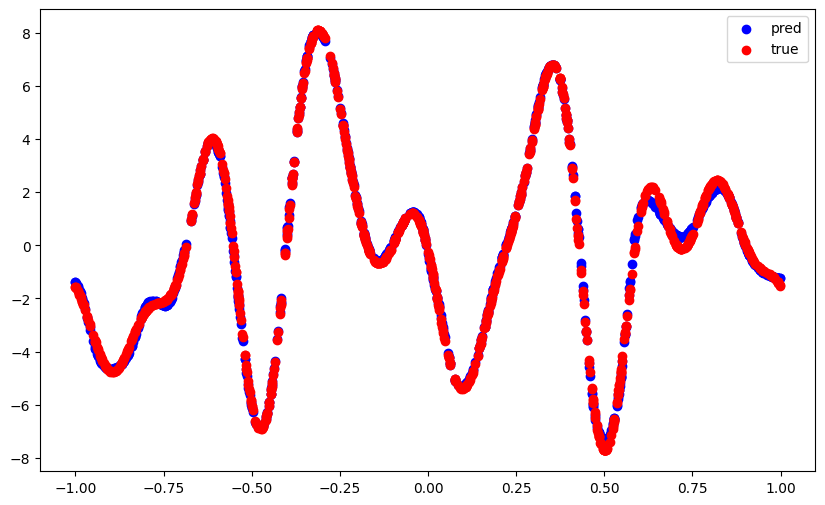

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(sample_x.flatten(), mlp.apply(mlp_params, sample_x).flatten(), color='b', label='pred')
plt.scatter(sample_x.flatten(), true_y.flatten(), color='r', label='true')
plt.legend()

### Train a proxy-based model

In [46]:
regressor = nn.Sequential((
    SimpleManifoldRegressor(n_proxies=2, output_dim=2),
    SimpleManifoldRegressor(n_proxies=2, output_dim=2),
    SimpleManifoldRegressor(n_proxies=2)
))
smr_params = regressor.init(random.PRNGKey(1), jnp.ones((10, 1)))

In [47]:
def calculate_smr_param_count():
    smr_param_count = 0

    def add_smr_param_count(x):
        nonlocal smr_param_count
        smr_param_count += jnp.size(x)
    
    tree_util.tree_map(add_smr_param_count, smr_params)
    
    return smr_param_count

smr_param_count = calculate_smr_param_count()

print(f'Simple Manifold Regressor parameter count: {smr_param_count}')

def smr_loss(params, x, y):
    y_pred = regressor.apply(params, x)
    return jnp.mean((y.flatten() - y_pred.flatten()) ** 2)

smr_grad_fn = jax.jit(jax.value_and_grad(smr_loss))
smr_optimizer = optax.adam(1e-2)
smr_opt_state = smr_optimizer.init(smr_params)
smr_losses = []

iterations = tqdm(range(2000))
for i in iterations:
    loss, grads = smr_grad_fn(smr_params, sample_x, true_y)
    updates, smr_opt_state = smr_optimizer.update(grads, smr_opt_state)
    smr_params = optax.apply_updates(smr_params, updates)
    iterations.set_description(f'iteration {i}; loss = {loss: .2e}')
    smr_losses.append(loss)

Simple Manifold Regressor parameter count: 42


iteration 1999; loss =  5.94e+00: 100%|██████████| 2000/2000 [00:22<00:00, 89.84it/s]


In [48]:
px.line(x=range(len(smr_losses)), y=smr_losses)

In [49]:
centers_1= smr_params['params']['layers_0']['centers'].flatten()

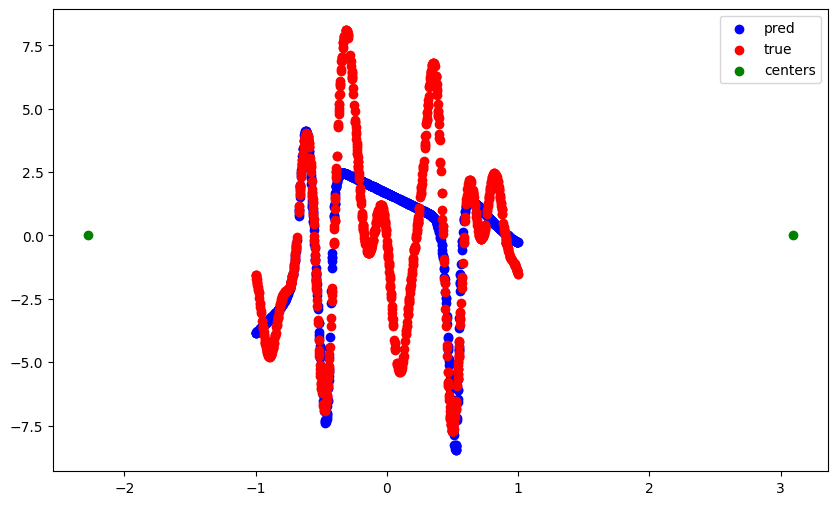

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(sample_x.flatten(), regressor.apply(smr_params, sample_x).flatten(), color='b', label='pred')
plt.scatter(sample_x.flatten(), true_y, color='r', label='true')
plt.scatter(centers_1, jnp.zeros((centers_1.shape[0],)), color='g', label='centers')
plt.legend()
plt.show()